# Removing noise from *K2* and *TESS* light curves using Pixel Level Decorrelation (`PLDCorrector`)

## Learning Goals

By the end of this tutorial, you will:

* Understand how to apply the [Lightkurve](https://docs.lightkurve.org) `PLDCorrector` tool to remove instrumental noise from *K2* and *TESS* light curves.
* Be able to create an exoplanet transit mask and use it to improve PLD.
* Be aware of common issues, caveats, and potential biases associated with the use of PLD.

## Introduction

The [*K2*](https://archive.stsci.edu/k2) and [*TESS*](https://archive.stsci.edu/tess) missions both provide high-precision photometry for thousands of exoplanet candidates. However, observations by both telescopes can be muddled by instrumental systematic trends, making exoplanet detection or stellar characterization difficult.

Pixel Level Decorrelation (PLD) is a method that has primarily been used to remove systematic trends introduced by small spacecraft motions during observations, and has been shown to be successful at improving the precision of data taken by the *Spitzer* space telescope ([Deming et al. 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...805..132D/abstract)) and the *K2* mission ([Luger et al. 2016](https://ui.adsabs.harvard.edu/abs/2016AJ....152..100L/abstract); [2018](https://ui.adsabs.harvard.edu/abs/2018AJ....156...99L/abstract)). PLD works by identifying a set of trends in the pixels surrounding the target star, and performing linear regression to create a combination of these trends that effectively models the systematic noise introduced by spacecraft motion. This noise model is then subtracted from the uncorrected light curve.

This method has been shown to be very effective at removing the periodic systematic trends in *K2*, and can also help remove the scattered light background signal in *TESS* observations. This tutorial will demonstrate how to use the [Lightkurve](https://docs.lightkurve.org) `PLDCorrector` for each mission, and will give advice on how to best implement PLD. The `PLDCorrector` is a special case of the [Lightkurve](https://docs.lightkurve.org) `RegressionCorrector`. For more information on how to use `RegressionCorrector` to choose custom regressors and remove scattered light from *TESS*, please see the tutorial specifically on removing scattered light from *TESS* data using the Lightkurve `RegressionCorrector`.

Before reading this tutorial, it is recommended to first familiarize yourself with using target pixel file (TPF) products and light curve products with Lightkurve.

## Imports

We only need to import the **[Lightkurve](https://docs.lightkurve.org)** package for this tutorial, which in turn uses **[Matplotlib](https://matplotlib.org/)** for plotting.

In [1]:
import lightkurve as lk
from lightkurve.correctors import PLDCorrector
%matplotlib inline

---

## 1. Applying PLD to a *K2* Light Curve

The dominant source of noise in *K2* data is created by the motion of the *Kepler* spacecraft due to periodic thruster firings. This causes stars to drift across different pixels on the detector, which have varied sensitivity. There are two classes of sensitivity variation on a charge-couped device (CCD) detector — variation between pixels (inter-pixel) and variation within each pixel (intra-pixel). Both inter- and intra-pixel sensitivity variations are present on the *Kepler* detector, which ultimately causes different flux levels to be detected as the target's Point Spread Function (PSF) drifts across the variations, introducing the systematic trends.

The `PLDCorrector` uses information from nearby pixels to create a noise model, so we need to use the `TargetPixelFile` data product (for more information, see the tutorial on using *Kepler* target pixel file products). We can use the `search_targetpixelfile` method to identify available observations for the desired target, and the `download` method to access the data.

In what follows below, we will demonstrate PLD on the exoplanet system K2-199, which was observed during *K2* Campaign 6. We can download the pixel data as follows:

<AxesSubplot:title={'center':'Target ID: 212779596, Cadence: 111362'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

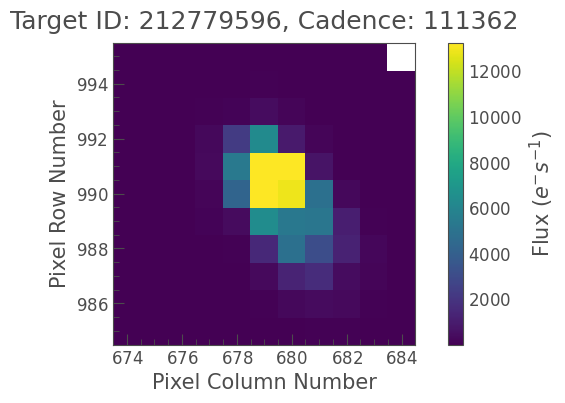

In [2]:
tpf = lk.search_targetpixelfile('K2-199', author='K2', campaign=6).download()
tpf.plot();

There are two ways to create a `PLDCorrector` object. The first is to create an instance of the class directly and pass in the `TargetPixelFile`.

In [3]:
pld = PLDCorrector(tpf)
print(pld)

PLDCorrector (ID: EPIC 212779596)


For convenience, you can also use the `to_corrector` method of the `TargetPixelFile` object, and pass in the string `'pld'` to specify the desired corrector type.

In [4]:
pld = tpf.to_corrector('pld')
print(pld)

PLDCorrector (ID: EPIC 212779596)


Both of these approaches return an identical `PLDCorrector` object. From here, getting a corrected light curve is possible: call the `correct` method.

In [5]:
corrected_lc = pld.correct()

Now we can compare the output of PLD to an uncorrected light curve. To create the uncorrected light curve, we can use the `to_lightcurve` method of the `KeplerTargetPixelFile` object, which performs simple aperture photometry (SAP) to create a light curve from the pixel data.

Below, the uncorrected light curve is shown in red and the PLD-corrected light curve is plotted in black. 

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

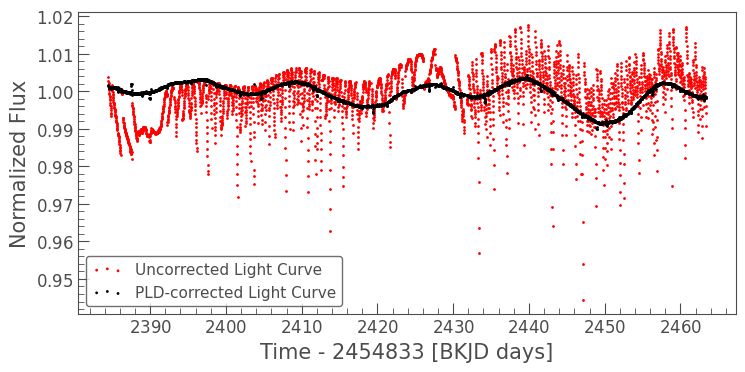

In [6]:
# Create and plot an uncorrected light curve using Simple Aperture Photometry
uncorrected_lc = tpf.to_lightcurve()
ax = uncorrected_lc.normalize().scatter(color='red', label='Uncorrected Light Curve');
# Plot the PLD-corrected light curve in black on top
corrected_lc.normalize().remove_outliers().scatter(ax=ax, color='black', label='PLD-corrected Light Curve');

The uncorrected light curve is dominated by a short period (about six hours) sawtooth-shaped pattern caused by the *Kepler* spacecraft thruster firings. PLD captures this trend in the noise model and has subtracted it, leaving the much more accurate light curve in black.

We can quantify the improvement by comparing the Combined Differential Photometric Precision (CDPP) values for each light curve.

In [7]:
uncorrected_cdpp = uncorrected_lc.estimate_cdpp()
corrected_cdpp = corrected_lc.estimate_cdpp()
print(f"Uncorrected CDPP = {uncorrected_cdpp:.0f}")
print(f"Corrected CDPP = {corrected_cdpp:.0f}")

Uncorrected CDPP = 2928 ppm
Corrected CDPP = 106 ppm


By this metric, the photometric precision improved by more than a factor of 25 after applying PLD. 

Another important trait of PLD is that long-term variability trends in the light curve are preserved. In this example, we can see the stellar rotation of K2-199 as the sinusoidal signal left in the light curve after correction. This is done by fitting a polynomial spline model to the light curve while simultaneously fitting the noise model, because the uncorrected observation is a combination of the signals. 

## 2. Diagnosing the Success of the Correction

The success of PLD depends on a number of factors including the brightness of the object, the choice of pixels used to create the light curve and the noise model, and whether or not there exists a correlation between the instrumental noise and the astrophysical signals. For these reasons, it is important to carefully review the correct operation of the algorithm each time you use it, and tune the optional parameters of the algorithm if necessary.

The most convenient way to diagnose the performance of PLD is to use the `diagnose()` method, which generates a set of diagnostic plots which we will explain below the graph.

array([<AxesSubplot:ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>,
       <AxesSubplot:ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>,
       <AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>],
      dtype=object)

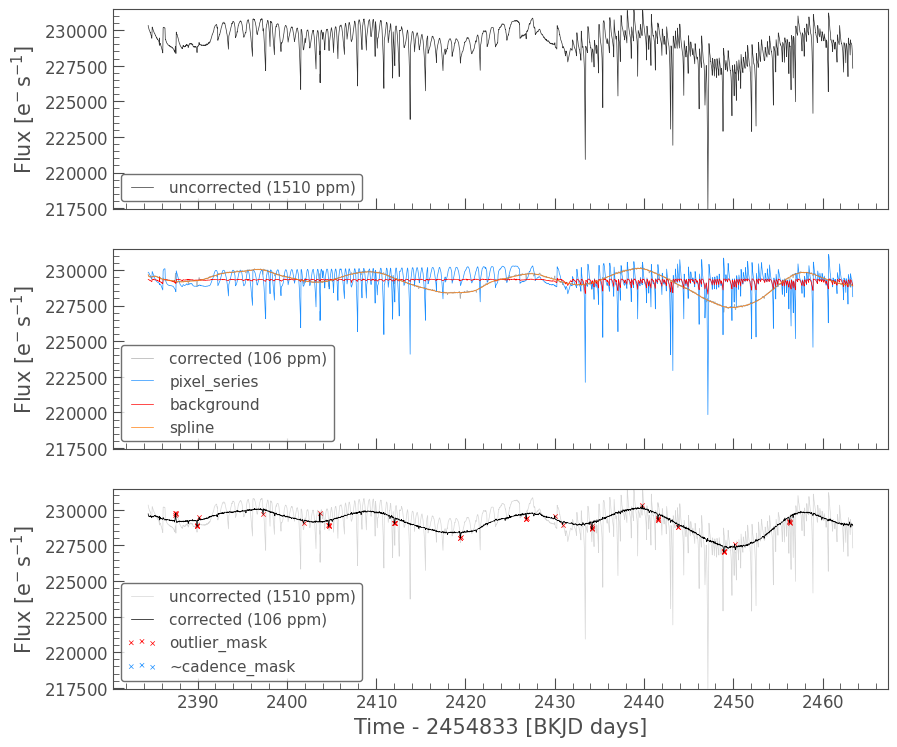

In [8]:
pld.diagnose();

The diagnostic plot is composed of the following panels:
- **Top panel**: The uncorrected light curve (`original`) is shown in black, with the Combined Differential Photometric Precision (CDPP), a measurement of the light curve's scatter, noted in the legend. 
- **Middle panel**: The PLD-corrected light curve (`corrected`) is plotted in gray with the noise model created by the combination of pixel values (`pixel_series`) in blue, the estimated background trend (`background`) in red, and the polynomial spline fit to the stellar variability (`spline`) in yellow. For *K2*, the background signal is minimal compared to the systematic trends due to motion, but it is much more significant for *TESS* observations. Notice that the corrected light curve closely matches the spline, which is tracing the preserved stellar variability.
- **Bottom panel**: A direct comparison between the uncorrected light curve (`original`) and the PLD-corrected light curve (`corrected`), again noting the CDPP of each light curve in the legend. This panel also indicates which cadences were flagged as outliers (`outlier_mask`), which lie greater than five standard deviations above or below the light curve, as well as which cadences are excluded from the spline fit (`~cadence_mask`). As we will see below, `cadence_mask` is a Boolean array with the same length as the `TargetPixelFile`'s time array, where `True` is included in the spline fit and `False` is excluded. The tilde (`~`) indicates that the inverse of the mask is marked in this plot, that is, the excluded cadences will be crossed out in blue. 

The plot above makes it convenient to review the components of the noise removal algorithm. The performance of the algorithm is strongly affected by the choice of pixels which go into the model components. To diagnose this part of the algorithm, we can use the `diagnose_masks` method:

array([<AxesSubplot:title={'center':'aperture_mask'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>,
       <AxesSubplot:title={'center':'pld_aperture_mask'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>,
       <AxesSubplot:title={'center':'background_aperture_mask'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>],
      dtype=object)

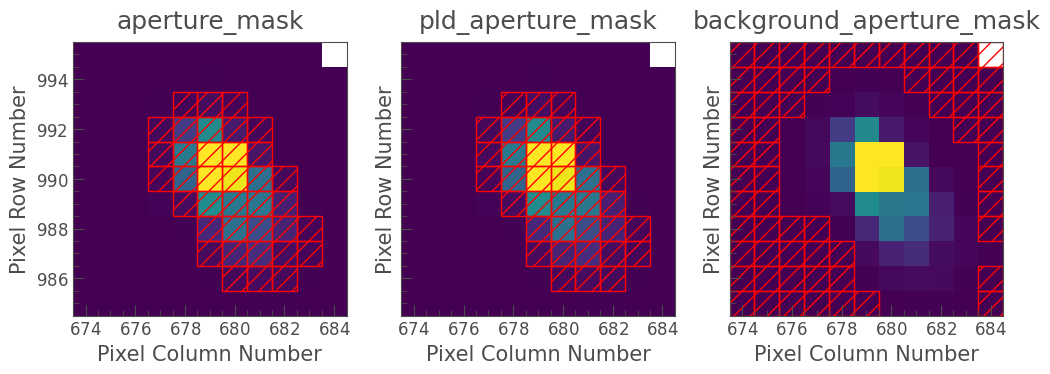

In [9]:
pld.diagnose_masks();

The panels in the figure visualize the following pixel masks:

* `aperture_mask`: Pixels used to create the SAP flux light curve from which the noise model is subtracted. 

* `pld_aperture_mask`: Pixels used to create the correlated noise model. 

* `background_aperture_mask`: Pixels used to create the background model. 


You can alter the `pld_aperture_mask` and `background_aperture_mask` by passing them as optional arguments to the `correct()` method we used earlier. For more information about these masks, and how to use them effectively, please see the full list of optional parameters and FAQ at the end of this tutorial.

## 3. How to Avoid Overfitting Exoplanet Transits

In the example above, it looks like PLD did a great job of removing the instrumental noise introduced by the *K2* detector drift, but the bottom panel of the diagnostic plot seems to indicate that we've falsely labeled in-transit data points as outliers. To alleviate this, we can introduce the `cadence_mask`.

### 3.1 Overfitting

It's necessary to mask out transits and flares when fitting the spline. The spline term fits a polynomial to the long-term trend of the light curve, and the highest likelihood solution generally follows the median of the corrected light curve. The presence of transits or flares can pull the median of the light curve down or up, respectively, causing the spline to deviate from the underlying stellar trend. 

In practice, this causes transits to be partially "fit out" by the spline, reducing their depth and giving an incorrect estimate of the planet's radius.

You can use a custom `cadence_mask` by creating a Boolean array with one value per cadence, where `True` indicates a cadence you wish to include and `False` means that the cadence is masked out.

For this example, we want to be sure that the in-transit cadences are not marked as outliers or used in the spline fit, as they can cause the spline to erroneously deviate from the stellar signal. To accomplish this, we can create a transit mask using the `create_transit_mask` method of the `LightCurve` object, using the known parameters of the planet system:

In [10]:
transit_mask = corrected_lc.create_transit_mask(period=[3.2277, 7.3745],
                                                duration=[0.25, 0.25], 
                                                transit_time=[2385.6635, 2389.9635]) 

We can double-check to make sure the transit mask looks good by plotting it on top of the corrected light curve in red:

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

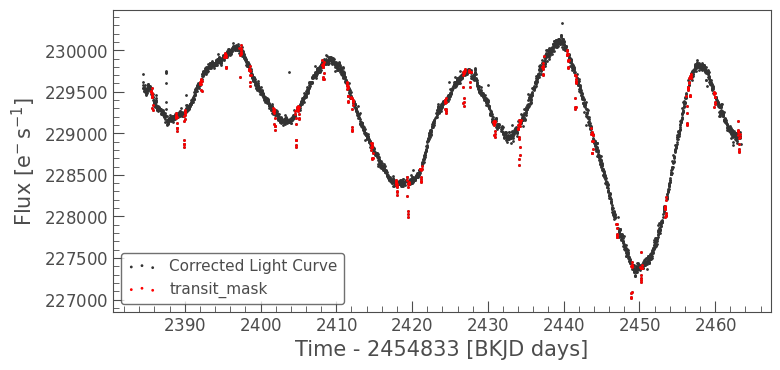

In [11]:
ax = corrected_lc.scatter(label='Corrected Light Curve')
corrected_lc[transit_mask].scatter(ax=ax, c='r', label='transit_mask');

The red points appear to match the in-transit cadences for both of the planets around K2-199. 

An additional option for the `PLDCorrector` is the ability to remove the long-term trend. This is ideal for planet candidates, which can be more difficult to detect in the presence of stellar variability. Here, we can set the `restore_trend` parameter to `False` in order to return a light curve with the long-period trend removed.

Now, we can call the `correct` method of the `PLDCorrector` again, this time passing in our `cadence_mask`.

array([<AxesSubplot:ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>,
       <AxesSubplot:ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>,
       <AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>],
      dtype=object)

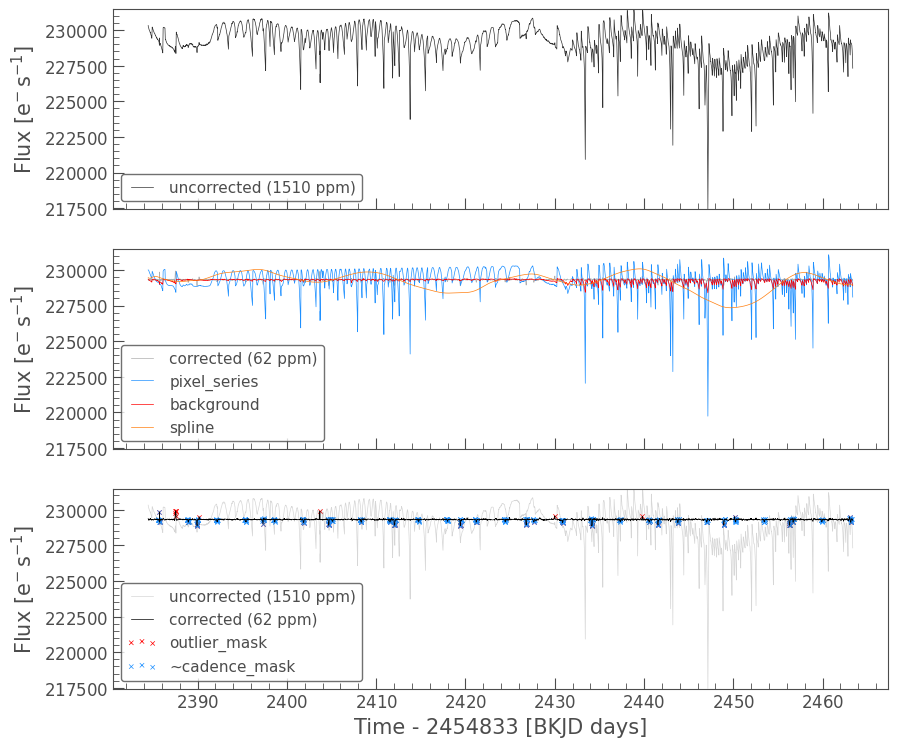

In [12]:
corrected_lc = pld.correct(cadence_mask=~transit_mask, restore_trend=False)
pld.diagnose();

Now, only points that are greater than five standard deviations above or below the light curve but not in-transit will be marked as outliers, and the in-transit points (marked in blue in the bottom panel) will not be used to fit the spline.

If we examine the light curve and its cadence mask again, we will see that the long-period trend has been removed, and the transits are clearly visible by eye.

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

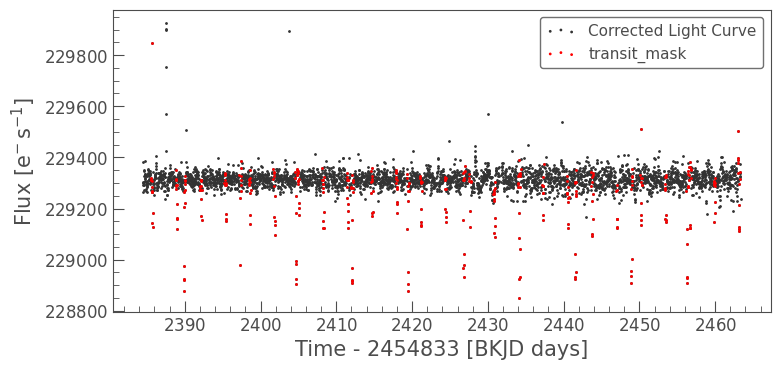

In [13]:
ax = corrected_lc.scatter(label='Corrected Light Curve')
corrected_lc[transit_mask].scatter(ax=ax, c='r', label='transit_mask');

This correction looks great! We have demonstrated that PLD is effective at removing systematic trends in *K2* data. Now, let's apply PLD to *TESS* observations.

## 4. Applying PLD to a *TESS* Light Curve



*TESS* has multiple observing modes. For example, there are two-minute cadence observations, which were retrieved for specific targeted objects, and there are 30-minute cadence Full Frame Images (FFIs), which capture the entire *TESS* field of view.

In this example, we will examine a target using the FFI observation. The *TESS* FFIs are dominated by the scattered light background signal on the *TESS* detector, which creates high-amplitude, periodic variation. This background can make planet detection difficult, but it can be removed using PLD. 

To access FFI data, we will use the [TESScut](https://mast.stsci.edu/tesscut/) tool on the Mikulski Archive for Space Telescopes (MAST), developed by [Brasseur et al. 2019](https://ui.adsabs.harvard.edu/abs/2019ascl.soft05007B/abstract). Lightkurve has a built-in search method for creating cutouts called `search_tesscut`, which uses the same syntax as the `search_targetpixelfile` method above. We will search for the Wolf-Rayet star WR 40, which was observed by *TESS* in Sector 10.

In [14]:
search_result = lk.search_tesscut('WR40', sector=10)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 10,2019,TESScut,1426,WR40,0.0


We can download the pixel data with the `download` method. When using TESScut, this method takes the additional parameter `cutout_size`, which determines how many pixels each side length of the cutout target pixel file should have.

Here, we use seven pixels on each side, which strikes a good balance between downloading enough pixels to create a good background model, and not downloading too many pixels, which can result in the corrector running slowly or including neighboring stars in the noise model.

<AxesSubplot:title={'center':'Target ID: WR40, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

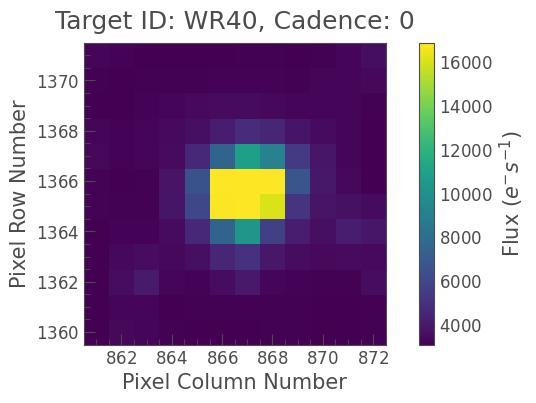

In [15]:
tpf = search_result.download(cutout_size=12)
tpf.plot();

We can create an uncorrected SAP light curve from this target pixel file using a threshold mask.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

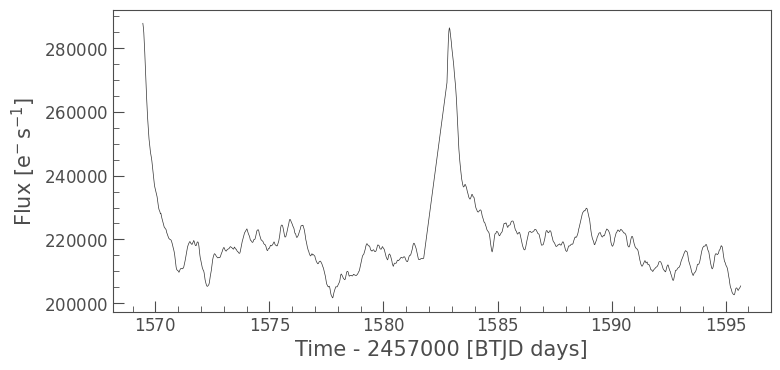

In [16]:
uncorrected_lc = tpf.to_lightcurve(aperture_mask='threshold')
uncorrected_lc.plot();

The dominant trend in the SAP light curve above is the dramatic ramp up in flux due to the scattered light background on the *TESS* detector. The pulsation signal of WR 40 can also be seen clearly, with some additional long-period variability. 

We will create a `PLDCorrector` object, and use the default values for `PLDCorrector.correct` to remove this scattered light background.

array([<AxesSubplot:ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>,
       <AxesSubplot:ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>,
       <AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>],
      dtype=object)

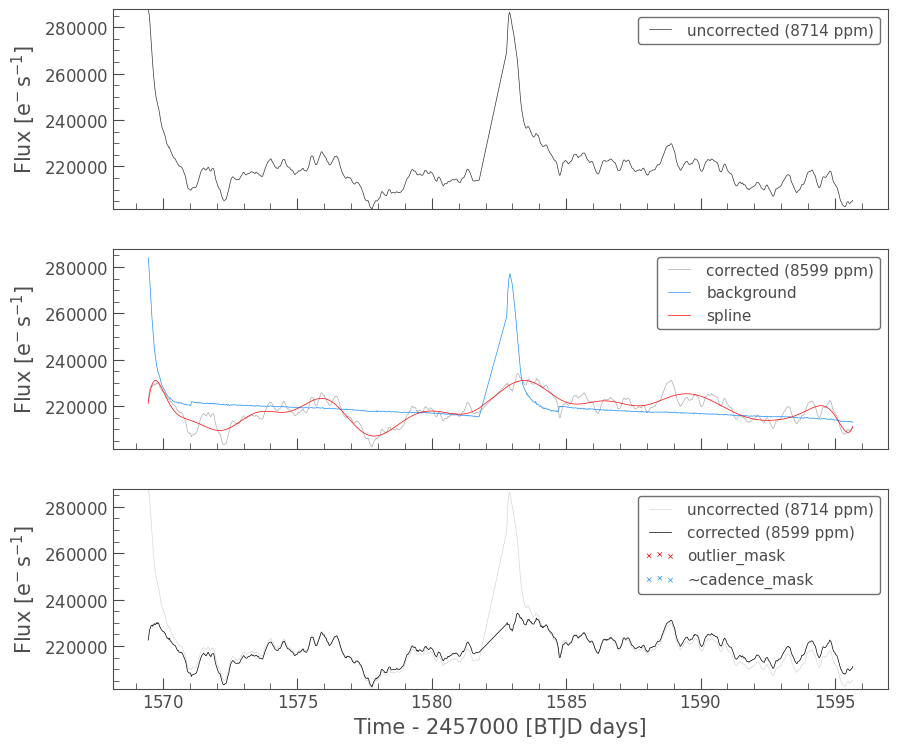

In [17]:
pld = PLDCorrector(tpf)
corrected_lc = pld.correct()
pld.diagnose();

The `background` component of the PLD model (shown in blue in the middle panel) has successfully isolated the large spikes without fitting out the pulsations of WR 40.

We can also examine the apertures used to perform this correction. For *TESS*, the dominant source of noise is the scattered light background, so by default only those pixels will be used. In the third panel, we can see that the `background_aperture_mask` contains only background pixels, reducing the risk of contamination by neighboring stars.

array([<AxesSubplot:title={'center':'aperture_mask'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>,
       <AxesSubplot:title={'center':'pld_aperture_mask'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>,
       <AxesSubplot:title={'center':'background_aperture_mask'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>],
      dtype=object)

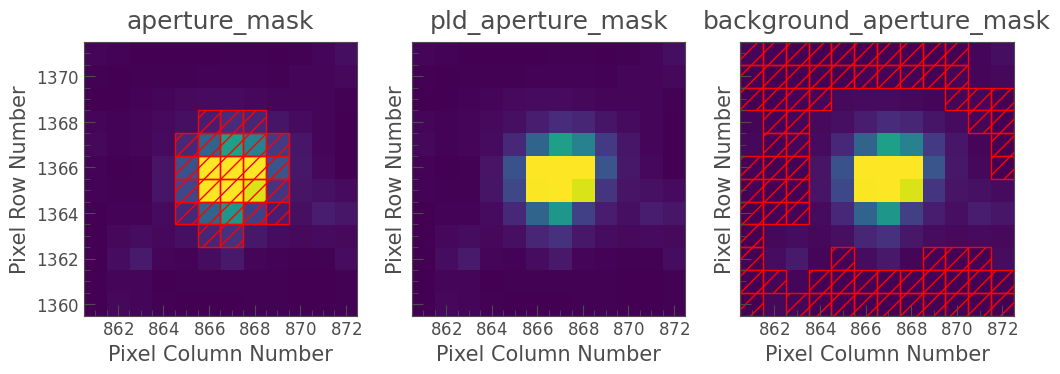

In [18]:
pld.diagnose_masks();

## 5. Tuning `PLDCorrector` Using Optional Parameters

In this section, we explore the optional parameters available when using the PLD method.

These keywords can be used to influence the performance of PLD. The PLD design matrix is constructed from three distinct submatrices, shown below with their corresponding keywords:
* **`background_model`**
  * `background_aperture_mask`
* **`pixel_series`**
  * `pld_order`
  * `pca_components`
  * `pld_aperture_mask`
* **`spline`**
  * `spline_n_knots`
  * `spline_degree`
  * `restore_trend`


### 5.1 Definitions of all additional parameters

Full descriptions of each of these keywords can be found below.

**`pld_order`** (`int`): 
* The order of Pixel Level Decorrelation to be performed. First order (`n=1`) uses only the pixel fluxes to construct the design matrix. Higher order populates the design matrix with columns constructed from the products of pixel fluxes. Default 3 for *K2* and 1 for *TESS*.
    
**`pca_components`** (`int` or tuple of `int`):
* Number of terms added to the design matrix for each order of PLD
pixel fluxes. Increasing this value may provide higher precision
at the expense of slower speed and/or overfitting. If performing PLD with `pld_order > 1`, `pca_components` can be a tuple containing the number of terms for each order of PLD. If a single `int` is passed, the same number of terms will be used for each order.  If zero is passed, Principle Component Analysis (PCA) will not be performed.
    
**`background_aperture_mask`** (`array-like` or `None`):
* A Boolean array flagging the background pixels such that `True` means
that the pixel will be used to generate the background systematics model.
If `None`, all pixels which are fainter than 1-sigma above the median flux will be used.
    
**`pld_aperture_mask`** (`array-like`, `'pipeline'`, `'all'`, `'threshold'`, or `None`):

* A Boolean array describing the aperture such that `True` means
that the pixel will be used when selecting the PLD basis vectors. If `None` or `all` are passed in, all pixels will be used. If `'pipeline'` is passed, the mask suggested by the official pipeline will be returned. If `'threshold'` is passed, all pixels brighter than 3-sigma above the median flux will be used.
    
**`spline_n_knots`** (`int`):
* Number of knots in spline.
    
**`spline_degree`** (`int`)
* Polynomial degree of spline.

**`restore_trend`** (`bool`):
* Whether to restore the long-term spline trend to the light curve.

**`sparse`** (`bool`):
* Whether to create `SparseDesignMatrix`.

**`cadence_mask`** (`np.ndarray` of `bool`) 
* (optional) Mask, where `True` indicates a cadence that should be used.

**`sigma`** (`int`):
* Standard deviation at which to remove outliers from fitting (default 5).

**`niters`** (`int`) 
* Number of iterations to fit and remove outliers (default 5).

**`propagate_errors`** (`bool`):
* Whether to propagate the uncertainties from the regression. Default is `False`. Setting to `True` will increase run time, but will sample from multivariate normal distribution of weights.

## 6. Frequently Asked Questions

**How should I select the pixels to use?**

As shown earlier, there are three aperture masks used in the `PLDCorrector`. 

* `aperture_mask`: Used to create the SAP flux light curve from which the noise model is subtracted. For this aperture, you should select as many pixels as possible that only contain flux from the target star. This is done automatically using a threshold mask, but it is a good idea to examine that mask with the `diagnose_masks` method to ensure it does not include background targets.

* `background_aperture_mask`: Pixels used to create the background model. These pixels should not contain flux from the target star whose light curve you are attempting to correct, nor should it contain flux from background targets. 

* `pld_aperture_mask`: Pixels used to create the correlated noise model. This aperture mask is more difficult to define, and may change on a case-by-case basis. For *K2*, this mask should contain as many pixels as possible in order to best capture the persistent motion-generated noise. For *TESS*, this mask should have less of an impact than the background mask, but should include all pixels in the cutout that do not contain background stars.

**How can I speed up the correction?**

The spline `DesignMatrix` used in `PLDCorrector` can be substituted for a `SparseDesignMatrix`. These behave identically to traditional `DesignMatrix` objects, but use `scipy.sparse` to speed up calculation and reduce memory. This can be done by passing in `sparse=True` to the `correct` method.

**What do I do if I get a singular matrix error?**

A singular matrix error occurs when a matrix used in `RegressionCorrector` cannot be inverted, a step necessary for optimizing the coefficients. The primary reason this occurs is that the input `DesignMatrix` has low rank relative to the number of column vectors. There are two suggested solutions to this issue:
*  Limit the number of input column vectors by performing Principle Component Analysis (PCA). This is done automatically in `PLDCorrector`, but the number of output PCA vectors can be reduced using the `pca_components` keyword in the `correct` method from its default value of 16.
* Ensure you are not masking out too much of your data. For instance, if you are using the `cadence_mask`, make sure that the values you want to include in your detrending are labeled as `True`. Using the inverse `cadence_mask` will often raise a singular matrix error.

## About this Notebook

**Authors**: Nicholas Saunders (nksaun@hawaii.edu), Geert Barentsen

**Updated**: September 29, 2020

## Citing Lightkurve and Astropy

If you use `lightkurve` or its dependencies in your published research, please cite the authors. Click the buttons below to copy BibTeX entries to your clipboard.

In [19]:
lk.show_citation_instructions()

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>
